# Overview

Here, we show a basic example of using the RCNN (Region-Based Conv. Neural Net) model for object detection.

The Region-Based Convolutional Neural Network, or R-CNN, is a family of convolutional neural network models designed for object detection, developed by [Ross Girshick, et al.](http://www.rossgirshick.info/)

There are perhaps four main variations of the approach, resulting in the current pinnacle called Mask R-CNN. The salient aspects of each variation can be summarized as follows:

R-CNN: Bounding boxes are proposed by the “selective search” algorithm, each of which is stretched and features are extracted via a deep convolutional neural network, such as AlexNet, before a final set of object classifications are made with linear SVMs.
Fast R-CNN: Simplified design with a single model, bounding boxes are still specified as input, but a region-of-interest pooling layer is used after the deep CNN to consolidate regions and the model predicts both class labels and regions of interest directly.
Faster R-CNN: Addition of a Region Proposal Network that interprets features extracted from the deep CNN and learns to propose regions-of-interest directly.
Mask R-CNN: Extension of Faster R-CNN that adds an output model for predicting a mask for each detected object.

__References__
1. [How to Use Mask R-CNN in Keras for Object Detection in Photographs](https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/)
2. [R-CNN, Fast R-CNN, Faster R-CNN, YOLO — Object Detection Algorithms](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e)
3. [source code: matterport - Mask_RCNN](https://github.com/matterport/Mask_RCNN)

# Install Libs

In [1]:
!pip install --upgrade JLpyUtils
!pip install Cython
!pip install pycocotools
import IPython.display
IPython.display.clear_output()

# Import Libs

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import importlib

In [3]:
import JLpyUtils
import JLpyUtils.ML.NeuralNet as NN

Using TensorFlow backend.


In [4]:
path_report_dir = os.path.abspath('../../../outputs/example-RCNN-mask-pretrained-coco')
if os.path.isdir(path_report_dir)==False:
    os.makedirs(path_report_dir)

# Load Pre-Trained Coco Model

Here, we will explore using the pretrained coco model

In [5]:
NN.RCNN.mask.utils.COCO_MODEL_URL

'https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5'

## Instantiate the model

In [6]:
coco = NN.RCNN.mask.model.pretrained.coco

In [7]:
path_coco_dir = os.path.join(path_report_dir, 'coco')
path_coco_dir
if not os.path.isdir(path_coco_dir):
    os.makedirs(path_coco_dir)

In [8]:
path_coco_model = os.path.join(path_coco_dir,'mask_rcnn_coco.h5')
path_coco_model

'/mr3_boltprod_john_t_leonard/Data_Science_Projects./ObjDetection/outputs/example-RCNN-mask-pretrained-coco/coco/mask_rcnn_coco.h5'

## Download the Weights

In [9]:
if not os.path.exists(path_coco_model):
    NN.RCNN.mask.utils.download_trained_weights(path_coco_model)

... done downloading pretrained model!


## Configurations

The configurations of the coco model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [10]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [11]:
importlib.reload(NN.RCNN)
importlib.reload(NN.RCNN.mask)
importlib.reload(NN.RCNN.mask.model)

<module 'JLpyUtils.ML.NeuralNet.RCNN.mask.model' from '/mr3_boltprod_john_t_leonard/Data_Science_Projects./ObjDetection/JLpyUtils/JLpyUtils/ML/NeuralNet/RCNN/mask/model.py'>

In [12]:
# Create model object in inference mode.
model = NN.RCNN.mask.model.MaskRCNN(mode="inference", 
                              model_dir=path_coco_dir, 
                              config=config)

# Load weights trained on MS-COCO
model.load_weights(path_coco_model, 
                   by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [13]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [16]:
path_img_dir = './Images'

Processing 1 images
image                    shape: (394, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


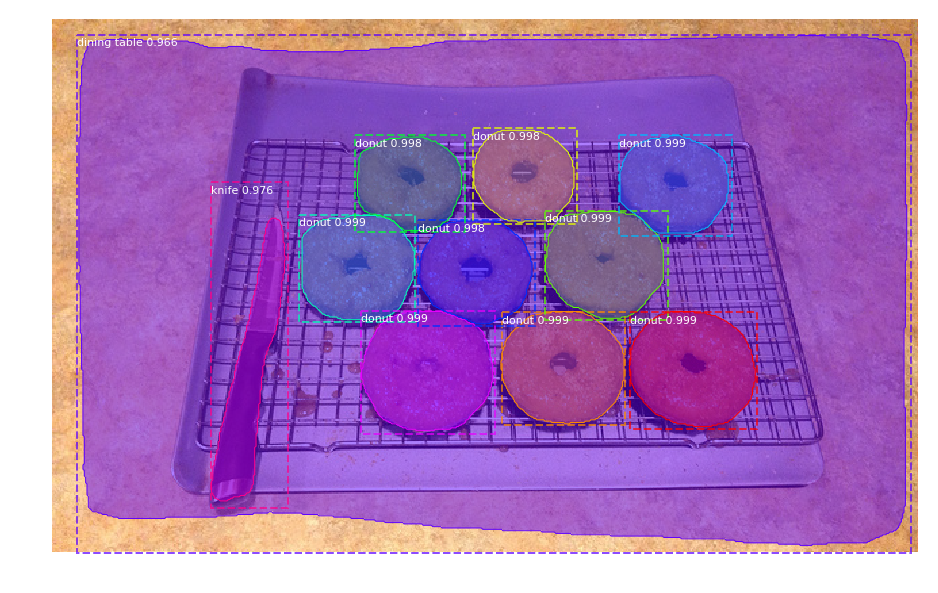

In [17]:
# Load a random image from the images folder
file_names = next(os.walk(path_img_dir))[2]
image = skimage.io.imread(os.path.join(path_img_dir, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
NN.RCNN.mask.visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])